# Building a Deep Neural Network: Step by Step

We're going to train a Neural Network with a single hidden layer and see how that handles the problem.
<center>
<img src="images/classification_kiank.png" style="width:600px;height:300px;"> </center>

In [161]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import copy
import sklearn.datasets

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='1'></a>
# 1 - Load the Dataset 

In [162]:
def load_planar_dataset_train():
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

def load_planar_dataset_test():
    np.random.seed(2)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [163]:
X_train, Y_train = load_planar_dataset_train()
X_test, Y_test = load_planar_dataset_test()

The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. The goal is to build a model to fit this data. In other words, we want the classifier to define regions as either red or blue.

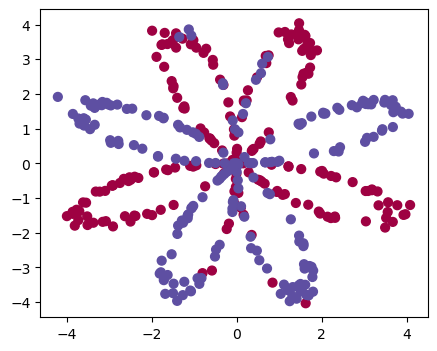

In [164]:
# Visualize the data:
plt.scatter(X_train[0, :], X_train[1, :], c=Y_train, s=40, cmap=plt.cm.Spectral);

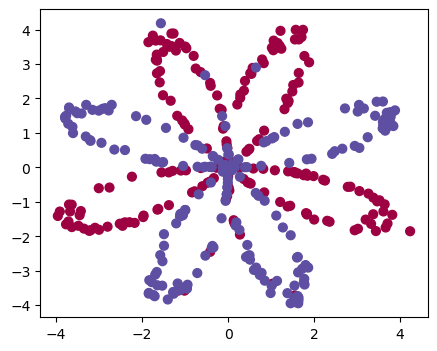

In [165]:
plt.scatter(X_test[0, :], X_test[1, :], c=Y_test, s=40, cmap=plt.cm.Spectral);

We have:

    - a numpy-array (matrix) X that contains your features (x1, x2)
    - a numpy-array (vector) Y that contains your labels (red:0, blue:1).

First, get a better sense of what your data is like. How many training examples do we have? In addition, what is the `shape` of the variables `X` and `Y`? 

In [166]:
shape_X = X_train.shape
shape_Y = Y_train.shape
# training set size
m = shape_X[1] 

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


<a name='2'></a>
## 2 - Neural Network model

The general methodology to build a Neural Network is to:

    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)
    4. Merge the loops into one function  



<a name='2-1'></a>
### 2.1 - Defining the neural network structure ####

- n_x: the size of the input layer
- n_h: the size of the hidden layer 
- n_y: the size of the output layer

In [167]:
def layer_sizes(X, Y,H=4):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    n_x = X.shape[0]
    n_h = H
    n_y = Y.shape[0]
    
    return (n_x, n_h, n_y)

<a name='2-2'></a>
### 2.2 - Initialize the model's parameters ####

We initialize the weights matrices with random values and the bias vectors as zeros. 

In [168]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """    
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

<a name='2-3'></a>
### 2.3 - forward_propagation

First we are going to define the sigmoid funciton

In [169]:
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

Now we Implement `forward_propagation()` using the following equations:

$$Z^{[1]} =  W^{[1]} X + b^{[1]}\tag{1}$$ 
$$A^{[1]} = \tanh(Z^{[1]})\tag{2}$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}\tag{3}$$
$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})\tag{4}$$

In [170]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1, X)+b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1)+b2
    A2 = sigmoid(Z2)

    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

Values needed in the backpropagation are stored in "cache". The cache will be given as an input to the backpropagation function.

<a name='2-4'></a>
### 2.4 - Compute the Cost

Now that we've computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for all examples, we can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

In [171]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    m = Y.shape[1] # number of examples

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2),Y) +np.multiply((1-Y), np.log(1-A2))
    cost = - 1/m*np.sum(logprobs) 
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    
    return cost

<a name='2-5'></a>
### 2.5 - Implement Backpropagation

Using the cache computed during forward propagation, we can now implement backward propagation.

Backpropagation is usually the hardest (most mathematical) part in deep learning. we'll will use the six equations on the right of this slide, since we are building a vectorized implementation.  


<center><img src="images/grad_summary.png" style="width:600px;height:300px;"></center>
<caption><center><font color='purple'><b>Figure 1</b>: Backpropagation. </font></center></caption>

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->


In [172]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    W2 = parameters["W2"]
 
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]

    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2-Y
    dW2 = 1/m*dZ2@A1.T
    db2 = 1/m*np.sum(dZ2, axis = 1, keepdims= True)
    dZ1 = W2.T@dZ2*(1 - np.power(A1, 2))
    dW1 = 1/m*dZ1@X.T
    db1 = 1/m*np.sum(dZ1, axis =1 , keepdims= True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

<a name='2-6'></a>
### 2.6 - Update Parameters 

We Implement the update rule Using gradient descent. 

$$\theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$$ 

where $\alpha$ is the learning rate and $\theta$ represents a parameter.



In [173]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve a copy of each parameter from the dictionary "parameters". Use copy.deepcopy(...) for W1 and W2
    W1 = copy.deepcopy(parameters["W1"])
    b1 = copy.deepcopy(parameters["b1"])
    W2 = copy.deepcopy(parameters["W2"])
    b2 = copy.deepcopy(parameters["b2"])
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # Update rule for each parameter
    W1 = W1 -learning_rate*dW1
    b1 = b1 -learning_rate*db1
    W2 = W2 -learning_rate*dW2
    b2 = b2 -learning_rate*db2 
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

<a name='2-7'></a>
### 2.7 - Integration

Integrate your functions in `nn_model()` to build the nerual network model

In [174]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    costs = []
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        # Cost function. Inputs: "A2, Y". Outputs: "cost".
        cost = compute_cost(A2, Y)
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads=backward_propagation(parameters, cache, X, Y)
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate = 1.2)
        
        if print_cost and i % 1000 == 0:
            # Record the costs
            costs.append(cost)
            # Print the cost every 1000 iterations
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters, costs

<a name='3'></a>
## 3 - Test the Model

<a name='3-1'></a>
### 3.1 - Predict

Predict with your model by building `predict()`.
Use forward propagation to predict results.

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
As an example, if you would like to set the entries of a matrix X to 0 and 1 based on a threshold you would do: ```X_new = (X > threshold)```

In [175]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 >0.5)
    
    return predictions

<a name='3-2'></a>
### 3.2 - Test the Model on test Planar Dataset

It's time to run the model and see how it performs on a planar dataset. 

In [176]:
# Build a model with a n_h-dimensional hidden layer
parameters, costs= nn_model(X_train, Y_train, n_h = 4, num_iterations = 10000, print_cost=True)

Cost after iteration 0: 0.693079
Cost after iteration 1000: 0.286813
Cost after iteration 2000: 0.245457
Cost after iteration 3000: 0.232243
Cost after iteration 4000: 0.226148
Cost after iteration 5000: 0.222262
Cost after iteration 6000: 0.219446
Cost after iteration 7000: 0.217271
Cost after iteration 8000: 0.219400
Cost after iteration 9000: 0.218512


In [177]:
# Plot the decision boundary
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

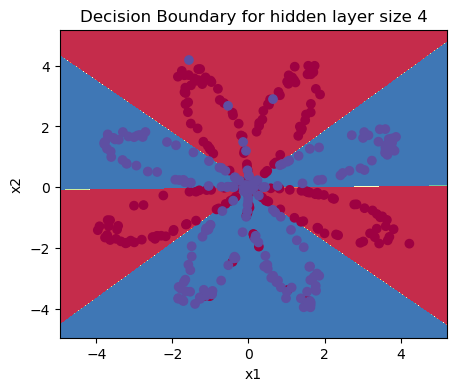

In [178]:
plot_decision_boundary(lambda x: predict(parameters, x.T), X_test, Y_test)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [179]:
# Print accuracy
predictions = predict(parameters, X_test)
print ('Accuracy: %d' % float((np.dot(Y_test, predictions.T) + np.dot(1 - Y_test, 1 - predictions.T)) / float(Y_test.size) * 100) + '%')

Accuracy: 90%


The model has learned the patterns of the flower's petals! Neural networks are able to learn highly non-linear decision boundaries. 

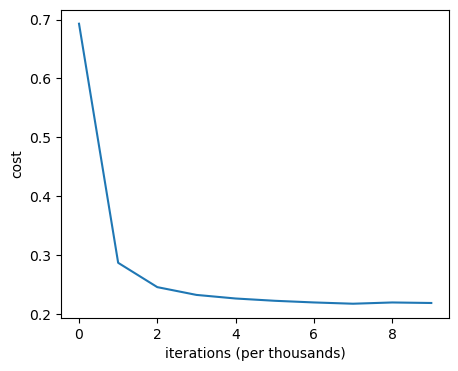

In [180]:
# Plot learning curve (with costs)
costs = np.squeeze(costs)
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per thousands)')
plt.show()